In [ ]:
#| default_exp rally

# Rally

> Easily analyze a pickleball rally

In [ ]:
#| hide
from nbdev.showdoc import *
from fastcore.test import *

from matplotlib.animation import FuncAnimation
%load_ext autoreload
%autoreload 2

In [9]:
#| export
from pklshop.data import *
from pklshop.stats import *
from pklshop.name import *
from pklshop.game import *
from pklshop.match import *
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from enum import Enum

In [31]:
set(shot.shot_type_orig.values)

{'A', 'D', 'E', 'L', 'O', 'R', 'SE', 'SP', 'tsDrp', 'tsDrv', 'tsL'}

In [36]:
#|export 

class ShotColor(Enum):
    SE = "green"
    D = "blue"
    tsDrp = "purple"
    tsDrv = "red"
    tsL = "orange"
    R = "black"
    L = "black"
    O = "black"
    A = "black"
    E = "black"
    SP = "black"
    

def shot_size(shot_num: int) -> int:
    if len(str(shot_num)) == 1:
        size=100
    else:
        size=200
    return size

def plot_court() -> None:
    '''
    Plots the empty pickleball court
    '''

    # Draw the court and non-volley zone
    plt.fill_between([0, 20], [-22, -22], [22, 22], color='darkblue', alpha=0.5)
    plt.fill_between([0, 20], [-7, -7], [7, 7], color='green', alpha=0.5)

    #Draw lines
    plt.plot([10, 10], [7.1, 22], color='white', linestyle='-', linewidth=1.5)
    plt.plot([10, 10], [-7.1, -22], color='white', linestyle='-', linewidth=1.5)
    plt.plot([0, 0], [-22, 22], color='white', linestyle='-', linewidth=2)
    plt.plot([20, 20], [-22, 22], color='white', linestyle='-', linewidth=2)
    plt.plot([0, 20], [22, 22], color='white', linestyle='-', linewidth=2)
    plt.plot([0, 20], [-22, -22], color='white', linestyle='-', linewidth=2)
    plt.plot([0, 20], [7, 7], color='white', linestyle='-', linewidth=2)
    plt.plot([0, 20], [-7, -7], color='white', linestyle='-', linewidth=2)

    #Draw net
    plt.plot([-0.5, 20.5], [0, 0], color='black', linestyle='-', linewidth=2)

    plt.axis('off')

def ball_travel_distance(x1: float, y1: float, x2: float, y2: float) -> float:
    ''' Returns the distance between two points'''
    return ((x1-x2)**2 + (y1-y2)**2)**0.5

def animate(i, ax, fig, position):
    # erase previous plot
    ax.cla()

    plot_court()
    fig.set_facecolor("lightblue")

    # draw point's trajectory
    ax.plot(
        position[: i + 1, 0],
        position[: i + 1, 1],
        linestyle="-",
        color="black",
        alpha=0.2,
    )

    # draw point's current position
    ax.plot(
        position[i, 0],
        position[i, 1],
        marker="o",
        markerfacecolor="yellow",
        markeredgecolor="yellow",
    )

    # fix axes limits
    ax.set_xlim(-2.5, 22.5)
    ax.set_ylim(-25, 25)

In [37]:
#| export
class Rally:
    """
    A class to represent a rally
    """
    def __init__(self, rally_id: str):
        self.rally_id= rally_id
        self.rally = rally[rally.rally_id == rally_id] # todo catch invalid rally number
        self.shot = shot[shot.rally_id == rally_id].sort_values("shot_nbr")
        self.rally_len = len(self.shot)
        self.shot_types = self.shot.shot_type_orig
        self.xcoords = [float(x_loc) for x_loc in self.shot.loc_x]
        self.ycoords = [float(y_loc) for y_loc in self.shot.loc_y]
        self.ycoords_flipped = self.flip_y()

        self.ball_travel_dists = self.get_ball_travel_dists()
        self.ball_travel_times = self.get_ball_travel_times()
        self.ball_speeds = [self.ball_travel_dists[i]/self.ball_travel_times[i] for i in range(len(self.ball_travel_dists))]

        
        self.serving_team_id = self.rally.srv_team_id.values[0]
        self.returning_team_id = self.rally.rtrn_team_id.values[0]
    
    def __str__(self):
        return f"Rally {self.rally_id}"
    __repr__ = __str__

    def flip_y(self) -> list[float]:
        ''' Flips the y coordinates of every other shot so that the coordinates accurately reflect the overall court'''
        y_arr = []
        for i, y in enumerate(self.ycoords):
            #Reverse the y location of every other shot
            if i % 2 == 0:
                y_arr.append(y)
            else:
                y_arr.append(-y) 
        return y_arr
    
    def get_ball_travel_dists(self) -> list[float]:
        ''' Returns a list of the distances traveled by the ball between each shot'''
        dists = []
        for i in range(len(self.xcoords)-1):
            dists.append(ball_travel_distance(self.xcoords[i], self.ycoords_flipped[i], self.xcoords[i+1], self.ycoords_flipped[i+1]))
        return dists
    
    def get_ball_travel_times(self) -> list[float]:
        ''' Returns a list of the times between each shot'''
        times = []
        for i in range(len(self.xcoords)-1):
            times.append(float(self.shot.btt_after.iloc[i]))
        return times

    def plot_rally(self) -> None:
        ''' Plots the rally'''
        n = range(1, len(self.xcoords) + 1)
        fig = plt.figure(figsize=(5,5.5))

        plot_court()

        for xi, yi, shoti, shot_num in zip(self.xcoords, self.ycoords_flipped, self.shot_types, n):
            
            color = ShotColor[shoti].value
            size = shot_size(shot_num)

            plt.scatter(xi, yi, marker=f'${shot_num}$', color=color, s=size, zorder=2)
        
        plt.text(10, 26, f"{get_team_name(self.serving_team_id)}", fontsize=20, color='black', zorder=3, horizontalalignment='center')
        plt.text(10, -28, f"{get_team_name(self.returning_team_id)}", fontsize=20, color='black', zorder=3, horizontalalignment='center')

        plt.xlim(-2.5, 22.5)
        plt.ylim(-24.5, 24.5)

        ax = plt.gca()
        ax.add_artist(ax.patch)
        ax.patch.set_zorder(-1)
        
        ax.set_facecolor('lightblue')
        fig.set_facecolor('lightblue')

        # plt.savefig("../figures/rally.png", facecolor=fig.get_facecolor())

        plt.show()

    def animate_rally(self) -> None:
        ''' Animates the rally and saves it as a gif in the figures directory'''
        N = 100
        speed_fac = 3

        xposinterp = np.array(
            [
                np.linspace(self.xcoords[i], self.xcoords[i + 1], int(N / speed_fac))
                for i in range(len(self.xcoords) - 1)
            ]
        ).flatten()
        yposinterp = np.array(
            [
                np.linspace(
                    self.ycoords_flipped[i], self.ycoords_flipped[i + 1], int(N / speed_fac)
                )
                for i in range(len(self.ycoords_flipped) - 1)
            ]
        ).flatten()
        position = np.array([xposinterp, yposinterp]).T

        # generate figure and axis
        fig, ax = plt.subplots(figsize=(5, 5))

        n_frames = len(xposinterp)
        # define the animation
        ani = FuncAnimation(fig=fig, func=animate, interval=20, frames=n_frames, fargs=(ax, fig, position))

        # show the animation
        # plt.show()
        ani.save("../figures/rally.gif", writer="pillow")
    

In [34]:
r = Rally("R1020")

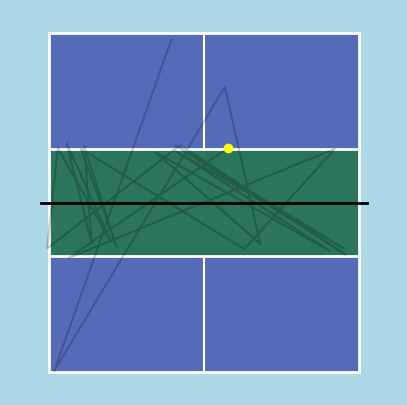

In [ ]:
r.animate_rally()

green
black
purple
blue
blue
blue
blue
blue
blue
blue
blue
blue
blue
blue
blue
blue
blue
blue
blue
blue
blue
blue
black


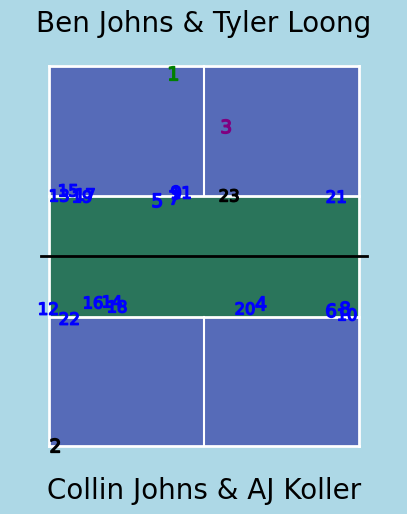

In [38]:
r.plot_rally()

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()